In [405]:
from bs4 import BeautifulSoup
import bs4 as bs
import urllib.request
import pandas as pd
import numpy as np
import re
import requests
from lxml import html
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [406]:
first_third=pd.read_csv('first_third_of_data.csv')
second_third=pd.read_csv('second_third_of_data.csv')
last_third=pd.read_csv('last_third_of_data.csv')

In [407]:
data=pd.concat([first_third, second_third,last_third], ignore_index=True)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [316]:
data.head()

,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,commentTitle,...,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,recipe_id,recipe_name
0,20158342.0,approved,20158342.0,1570140.0,Christa,<br/>,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,20158342.0,False,1015646,shredded oxtail salad with mustard and shallot
1,110917145.0,approved,110917145.0,87444971.0,Lindsey,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,110917145.0,False,1012940,aunt gens biscotti
2,104240855.0,approved,104240855.0,68602151.0,VFR Marc,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,104240855.0,False,1012940,aunt gens biscotti
3,16837960.0,approved,16837960.0,30298351.0,Joanne,<br/>,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,16837960.0,False,1017810,turkey dinner canapes
4,111016114.0,approved,111016114.0,57140404.0,Rachel,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,111016114.0,False,1019207,lalla mussa dal


--------- start running here if csv from web-scraper results is already downloaded ---------

In [408]:
ratings=pd.read_csv('ingredient_rating_df.csv')
ratings=ratings[ratings["rating"]!=' ']

In [409]:
ratings=ratings.reset_index()
ratings["rating"] =pd.to_numeric(ratings['rating'])

In [412]:
ratings
ratings.drop('index', axis=1, inplace=True)

In [413]:
data=data.join(ratings.set_index('recipe_id'), on='recipe_id', how='left')

Now we are going to use the dataset to try and develop a model that can predict a recipe's rating.
Some things that we will look at are:
- number of ingredients that a recipe requires
- the average sentiment of the comments left per recipe (can add a column to our dataset that has the average sentiment value of the comments left on a 
- the number of replies? 
- can also create a model and then run feature importance
- do we want to add calories and other nutritional information to the dataframe?
- regression model 
    - random forest regression 
- exploratory data analysis:
    - distributions of comments (how often are there no or many comments), sentiment analysis, ratings (usually bimodal)
    - word clouds
    
- may want to run data on only 40% of original data

# Exploratory Analysis

In [414]:
#Deal with NAs
data['rating'].isnull().values.any()
data.dropna(subset=['rating'],inplace=True)
data=data.reset_index()

In [416]:
neg=[]
pos=[]
neu=[]
comp=[]

overall_sentiment=[]
sia = SentimentIntensityAnalyzer()

for comment in range(len(data)):
    scores_dict=sia.polarity_scores(data.loc[comment,'commentBody'])
    neg_score=scores_dict['neg']
    neu_score=scores_dict['neu']
    pos_score=scores_dict['pos']
    compound_score=scores_dict['compound']
    
    if compound_score >= 0.05 :
        positive_count+=1
        overall_sentiment.append('positive')
 
    elif compound_score <= - 0.05 :
        negative_count+=1
        overall_sentiment.append('negative')
 
    else :
        neutral_count+=1
        overall_sentiment.append('neutral')

    neg.append(neg_score)
    neu.append(neu_score)
    pos.append(pos_score)
    comp.append(compound_score)

data['negative_polarity_score']=neg
data['positive_polarity_score']=pos
data['neutral_polarity_score']=neu
data['compound_polarity_score']=comp
data['overall_sentiment']=overall_sentiment

In [417]:
#recipe_df has the AVERAGE polarity scores for each recipe
recipe_df=pd.DataFrame(data.groupby('recipe_id').mean())
recipe_df=recipe_df.reset_index()
recipe_df=recipe_df[['recipe_id','num_ingredients','negative_polarity_score','positive_polarity_score','neutral_polarity_score','compound_polarity_score','rating']]
recipe_df['replyCount']=np.array(data.groupby('recipe_id').sum().replyCount)

In [418]:
comment_count_df=pd.DataFrame(data['recipe_id'].value_counts())
comment_count_df=comment_count_df.rename(columns={"recipe_id": "comment_count"})
comment_count_df.index.name='recipe_id'

comment_count_df=comment_count_df.reset_index()

recipe_df=recipe_df.join(comment_count_df.set_index('recipe_id'), on='recipe_id', how='left')

In [419]:
overall_sentiment=[]

positive_count=0
neutral_count=0
negative_count=0

for recipe in range(len(recipe_df)):
    neg_score=recipe_df.loc[recipe, 'negative_polarity_score']
    neu_score=recipe_df.loc[recipe, 'neutral_polarity_score']
    pos_score=recipe_df.loc[recipe, 'positive_polarity_score']
    compound_score=recipe_df.loc[recipe, 'compound_polarity_score']
    
    if compound_score >= 0.05 :
        positive_count+=1
        overall_sentiment.append('positive')
 
    elif compound_score <= - 0.05 :
        negative_count+=1
        overall_sentiment.append('negative')
 
    else :
        neutral_count+=1
        overall_sentiment.append('neutral')

In [420]:
recipe_df['overall_sentiment']=overall_sentiment

In [421]:
print(positive_count)
print(neutral_count)
print(negative_count)

8159
142
96


In [422]:
recipe_df

,recipe_id,num_ingredients,negative_polarity_score,positive_polarity_score,neutral_polarity_score,compound_polarity_score,rating,replyCount,comment_count,overall_sentiment
0,852,10.0,0.000000,0.110000,0.890000,0.273200,4.0,0.0,1,positive
1,1466,14.0,0.007758,0.172061,0.820152,0.479039,4.0,7.0,33,positive
2,1467,10.0,0.000000,0.045500,0.954500,0.136600,4.0,1.0,2,positive
3,1468,12.0,0.031167,0.181667,0.787083,0.529025,4.0,2.0,12,positive
4,1469,6.0,0.066125,0.118813,0.815063,0.195662,4.0,12.0,16,positive
...,...,...,...,...,...,...,...,...,...,...
8392,1022327,13.0,0.018100,0.205700,0.776200,0.605285,4.0,3.0,20,positive
8393,1022328,6.0,0.000000,0.101000,0.899000,0.309050,4.0,3.0,4,positive
8394,1022332,19.0,0.028667,0.166778,0.804556,0.517967,4.0,0.0,9,positive
8395,1022345,6.0,0.000000,0.454000,0.546000,0.846400,4.0,0.0,1,positive


/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_35810/3254857897.py:34: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


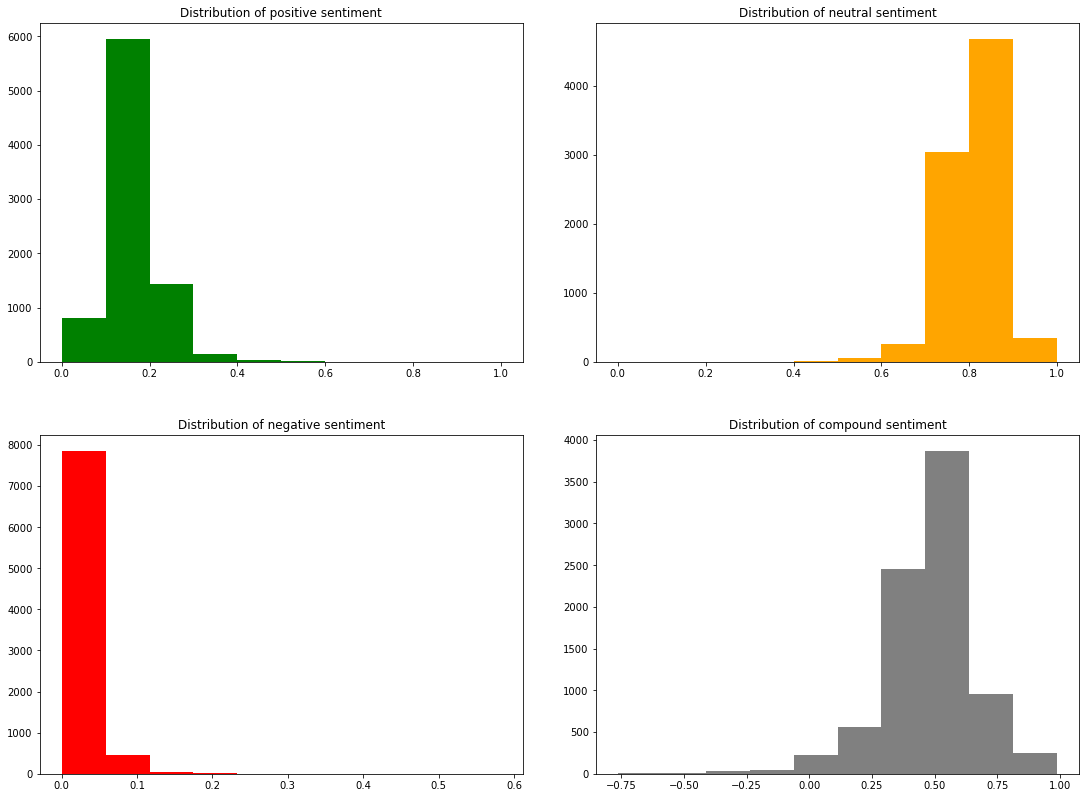

In [435]:
figure(figsize=(16, 12))

plt.subplot(2, 2, 1) # row column count
plt.hist(recipe_df['positive_polarity_score'], color='green')
plt.title('Distribution of positive sentiment')

plt.subplot(2, 2, 2) # row column count
plt.hist(recipe_df['neutral_polarity_score'], color='orange')
plt.title('Distribution of neutral sentiment')

plt.subplot(2, 2, 3) # row column count
plt.hist(recipe_df['negative_polarity_score'], color='red')
plt.title('Distribution of negative sentiment')

plt.subplot(2, 2, 4) # row column count
plt.hist(recipe_df['compound_polarity_score'], color='grey')
plt.title('Distribution of compound sentiment')


plt.tight_layout(4)

Text(0.5, 1.0, "Average Overall Sentiment of A Recipe's Comments")

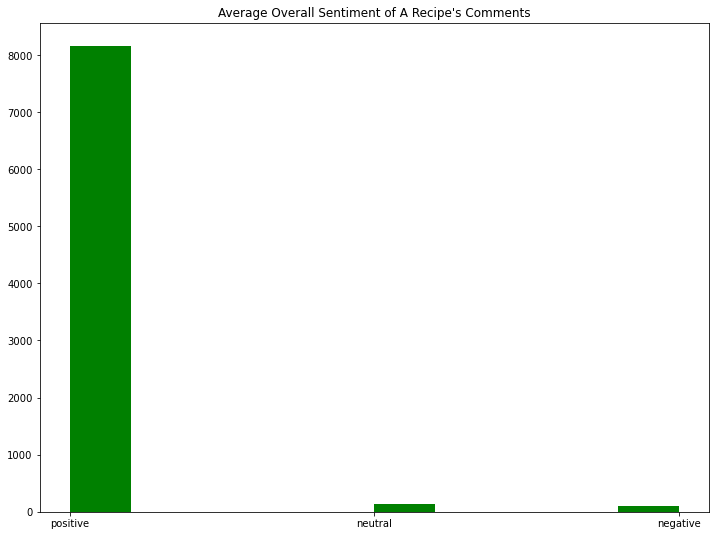

In [493]:
figure(figsize=(12, 9))

plt.hist(recipe_df['overall_sentiment'], color='green')
plt.title("Average Overall Sentiment of A Recipe's Comments")

In [436]:
positive_com_all=data[data['overall_sentiment']=='positive']
positive_com_all=positive_com_all.reset_index()
negative_com_all=data[data['overall_sentiment']=='negative']
negative_com_all=negative_com_all.reset_index()

In [437]:
positive_com=recipe_df[recipe_df['overall_sentiment']=='positive']
positive_com=positive_com.reset_index()
negative_com=recipe_df[recipe_df['overall_sentiment']=='negative']
negative_com=negative_com.reset_index()

/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_35810/2180435008.py:12: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


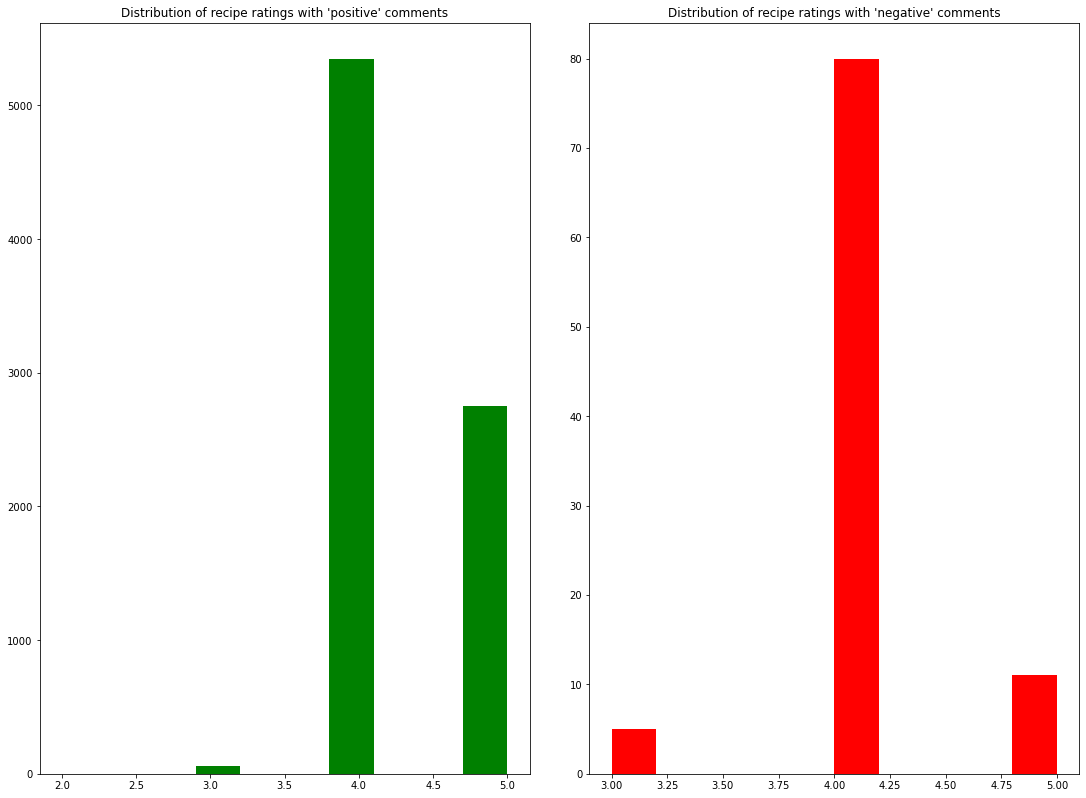

In [438]:
figure(figsize=(16, 12))

plt.subplot(1, 2, 1) # row column count
plt.hist(positive_com['rating'], color='green')
plt.title("Distribution of recipe ratings with 'positive' comments")

plt.subplot(1, 2, 2) # row column count
plt.hist(negative_com['rating'], color='red')
plt.title("Distribution of recipe ratings with 'negative' comments")


plt.tight_layout(4)

Text(0.5, 1.0, 'Distribution of Recipe Ratings')

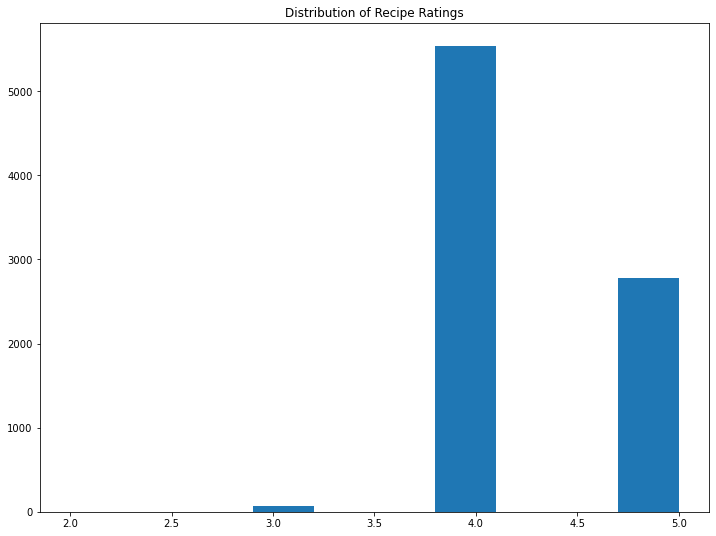

In [495]:
figure(figsize=(12, 9))

plt.hist(recipe_df['rating'])
plt.title('Distribution of Recipe Ratings')

Text(0.5, 1.0, 'Negative Comments')

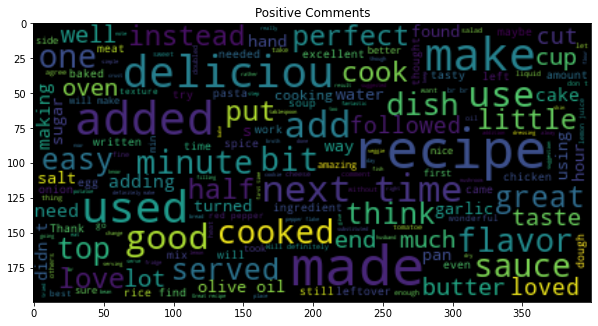

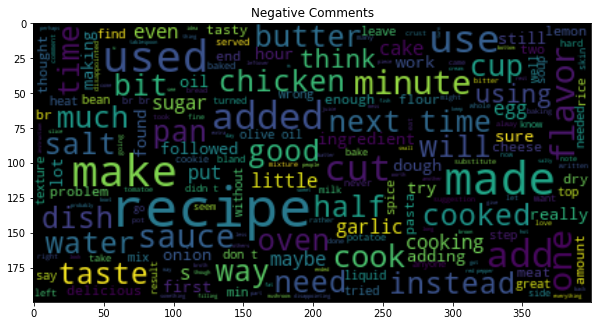

In [440]:
from wordcloud import WordCloud

positive_str=''
for row in range(len(positive_com_all)):
    positive_str=positive_str+positive_com_all.loc[row,'commentBody']

negative_str=''
for row in range(len(negative_com_all)):
    negative_str=negative_str+negative_com_all.loc[row,'commentBody']


wc = WordCloud(max_font_size=40).generate(positive_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear") 
plt.title("Positive Comments")

wc = WordCloud(max_font_size=40).generate(negative_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Comments")

Compare word clouds based on sentiment with word clouds based on ratings:

In [441]:
data=data[data['rating']!=' ']

In [442]:
data["rating"] = pd.to_numeric(data["rating"])

In [443]:
above_4=data[data['rating']>=4]
above_4=above_4.reset_index()
below_3=data[data['rating']<=3]
below_3=below_3.reset_index()

Text(0.5, 1.0, 'Comments for recipes that received a rating of 3 or below')

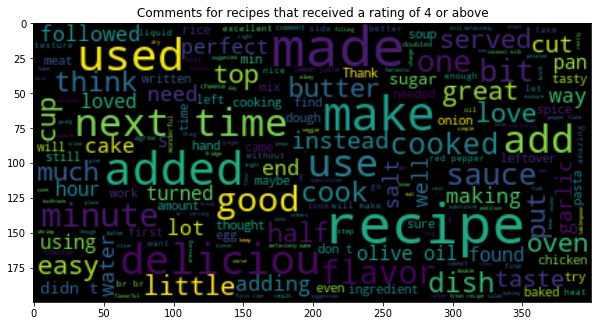

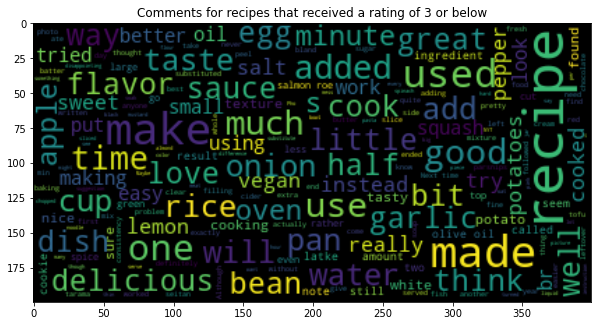

In [476]:
above4_str=''
for row in range(len(above_4)):
    above4_str=above4_str+above_4.loc[row,'commentBody']

below3_str=''
for row in range(len(below_3)):
    below3_str=below3_str+below_3.loc[row,'commentBody']

wc = WordCloud(max_font_size=40).generate(above4_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear") 
plt.title("Comments for recipes that received a rating of 4 or above")

wc = WordCloud(max_font_size=40).generate(below3_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.title("Comments for recipes that received a rating of 3 or below")

# Building Our Model

In [445]:
recipe_df.columns

Index(['recipe_id', 'num_ingredients', 'negative_polarity_score',
       'positive_polarity_score', 'neutral_polarity_score',
       'compound_polarity_score', 'rating', 'replyCount', 'comment_count',
       'overall_sentiment'],
      dtype='object')

In [446]:
features_list= ['replyCount','num_ingredients','negative_polarity_score','positive_polarity_score','neutral_polarity_score','compound_polarity_score','overall_sentiment','comment_count']
features=recipe_df[features_list]
target=recipe_df['rating']

In [447]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

lb.fit(features['overall_sentiment'])
lb.classes_
lb.transform(features['overall_sentiment'])

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [448]:
features[['negative_os','neutral_os','positive_os']]=lb.transform(features['overall_sentiment'])

/Users/Eva/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [449]:
features=features.drop(columns=['overall_sentiment'])

In [450]:
features_list.extend(['negative_os','neutral_os','positive_os'])

In [451]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.25)

In [452]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (6297, 10)
Training Labels Shape: (6297,)
Testing Features Shape: (2100, 10)
Testing Labels Shape: (2100,)


In [453]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [454]:
predictions = rf.predict(test_features)
errors = abs(np.around(predictions) - test_labels)

In [455]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.31 degrees.


In [456]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 93.1 %.


In [470]:
features_list.remove('overall_sentiment')

In [471]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: compound_polarity_score Importance: 0.23
Variable: positive_polarity_score Importance: 0.16
Variable: comment_count        Importance: 0.15
Variable: negative_polarity_score Importance: 0.14
Variable: neutral_polarity_score Importance: 0.13
Variable: num_ingredients      Importance: 0.11
Variable: replyCount           Importance: 0.08
Variable: negative_os          Importance: 0.0
Variable: neutral_os           Importance: 0.0
Variable: positive_os          Importance: 0.0


<AxesSubplot:title={'center':'Feature Importances'}>

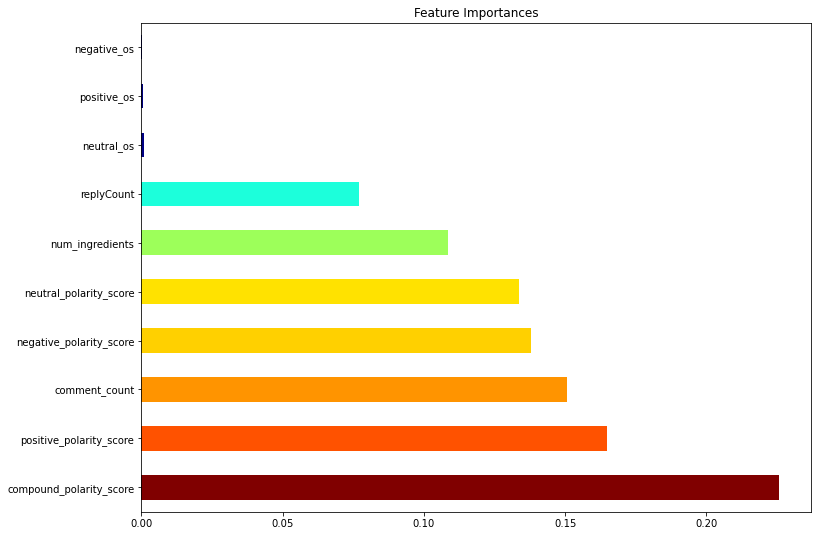

In [474]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
figure(figsize=(12, 9))
feat_importances = pd.Series(rf.feature_importances_, index=train_features.columns)
my_cmap=cm.get_cmap('jet')
my_norm=Normalize(vmin=0,vmax=0.2)
feat_importances.nlargest(20).plot(kind='barh',title="Feature Importances",color=my_cmap(my_norm(feat_importances.nlargest(20))))

In [461]:
np.around(predictions)

array([4., 4., 4., ..., 4., 4., 4.])

Our model only predicted ratings between 3-5. 

(array([   2.,    0.,    0.,    0.,    0., 1640.,    0.,    0.,    0.,
         458.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 10 artists>)

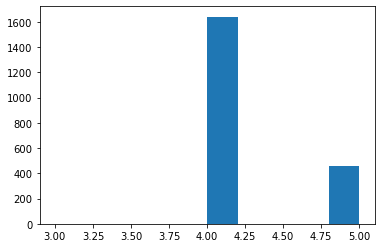

In [462]:
plt.hist(np.around(predictions))